Sistema baseado na rede de distribuição de gás natural

1 Duto

equações :
$$
\frac{\partial}{\partial t}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
=
\begin{bmatrix}
-w & 0 & -T \frac{V^{*} P'_T}{C_V} \\
0 & -w & V \\
- V^{*} P'_T & -V^{*} P'_V & -w
\end{bmatrix}
\frac{\partial}{\partial x}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
+
\begin{bmatrix}
\frac{f w^2 |w|}{2 D C_V} + \frac{q}{C_V} \\
0 \\
\frac{f w |w|}{2 D}
\end{bmatrix}
$$
Retirado da Tese de doutorado em Engenharia Industrial de Rodrigo Lima Meira.

| **Variável**      | **Valor**           | **Unidade**     |
|-------------------|---------------------|-----------------|
| 𝜀                 | 1,5 × 10⁻⁶          | m               |
| κₛₒₗₒ             | 0,89                | W/(m·K)         |
| Tₛₒₗₒ             | 15                  | °C              |
| zₛₒₗₒ             | 2                   | m               |


In [1]:
import casadi as ca
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from libs.viscosity import *
from libs.eos_database import *
from libs.gc_eos_soave import *
from libs.composicaogas import *
from libs.duto import *
from scipy.integrate import solve_ivp
from numpy import sum
from libs.duto_casadi import *

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

Vpp = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 8400, None, 1, 0, Aij, volumn_desviation, 'gas')
visc = viscosity(mixture, volumn_desviation)
D = 0.42
# Criar instância do duto com os parâmetros necessários  # ajuste conforme seu import real
meu_duto = duto(gas=gas, visc=visc,  Lc=200000, D=D)

# Número de nós (comprimento de self.l)
n_nodes = len(meu_duto.l)

0.99365 [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]
[0.9896844965531123, 0.006138982539123434, 0.0015095858702762542, 0.0003019171740552508, 0.0003019171740552508, 0.0005535148191012933, 0.0004025562320736678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003019171740552508, 0.0, 0.0008051124641473356, 0.0]


In [3]:
def erro_w0(w0_guess, duto, T0, V0, w_final_desejado):
    w0_guess = float(np.atleast_1d(w0_guess)[0])  # garante escalar puro
    y0 = [float(T0), float(V0), float(w0_guess)]
    
    sol = solve_ivp(
        lambda x, y: duto.estacionario(x, y),
        [0.0, duto.Lc],
        y0,
        method="RK45",
        rtol=1e-9,
        atol=1e-12
    )
    w_final_calc = float(sol.y[2, -1])
    return w_final_calc - w_final_desejado


# condições conhecidas
T_init = 300
P_init = 8400
gas_init = gas.copy_change_conditions(T_init, P_init, None, 'gas')
V_init = gas_init.V.item()     # Volume específico de entrada    
        
#saída [ | | | | |] => saída =>
  
Q_out = 4 # [m³/s]
A = np.pi * (D**2) / 4  # Área da seção transversal do duto
w_final_desejado = Q_out / A

# chute inicial para w0
w0_guess = 17

y_init = [T_init, V_init, w0_guess]

print(meu_duto.estacionario(0, y_init))

w0_sol, info, ier, msg = fsolve(
    erro_w0,
    [w0_guess],
    args=(meu_duto, T_init, V_init, w_final_desejado),
    xtol=1e-12,     # tolerância na solução (variáveis)
    full_output=True
)
print(w0_sol)


(-9.225090114077975e-05, 1.8183385937582805e-07, 1.181635093831639e-05)
[19.64349802]


In [4]:
y0 = [T_init, V_init, w0_sol[0]]


x_avaliar = meu_duto.l  

sol_estc = solve_ivp(
    lambda x, y: meu_duto.estacionario(x, y),
    [0.0, meu_duto.Lc],
    y0,
    t_eval=x_avaliar,
    method='RK45',
    rtol=1e-9,
    atol=1e-12
)

T_sol_estc = sol_estc.y[0]
V_sol_estc = sol_estc.y[1]
w_sol_estc = sol_estc.y[2]
P_sol_estc = []

for i in range(len(T_sol_estc)):
    gas2 = gas.copy_change_conditions(T_sol_estc[i], None, V_sol_estc[i], 'gas')
    P_current = gas2.P.item()
    P_sol_estc.append(P_current)




print(f"{'x [m]':>8} | {'T [K]':>8} | {'V [m³/kg]':>10} | {'w [m/s]':>10}")
print("-"*45)

for xi, Ti, Vi, wi, Pi in zip(x_avaliar, T_sol_estc, V_sol_estc, w_sol_estc, P_sol_estc):
    print(f"{xi:8.2f} | {Ti:8.2f} | {Vi:10.6f} | {wi:10.6f} | {Pi:10.6f}")

   x [m] |    T [K] |  V [m³/kg] |    w [m/s]
---------------------------------------------
   -0.00 |   300.00 |   0.261602 |  19.643498 | 8400.000000
 2233.83 |   299.77 |   0.262224 |  19.690214 | 8372.399852
 6651.60 |   299.33 |   0.263481 |  19.784590 | 8317.556355
13154.62 |   298.67 |   0.265396 |  19.928458 | 8236.185250
21597.62 |   297.84 |   0.268006 |  20.124419 | 8129.365741
31792.00 |   296.84 |   0.271352 |  20.375660 | 7998.547715
43510.04 |   295.71 |   0.275481 |  20.685714 | 7845.562133
56489.96 |   294.48 |   0.280441 |  21.058129 | 7672.635062
70441.83 |   293.18 |   0.286273 |  21.496048 | 7482.405574
85053.98 |   291.83 |   0.293006 |  22.001645 | 7277.946837
100000.00 |   290.46 |   0.300647 |  22.575405 | 7062.789858
114946.02 |   289.10 |   0.309167 |  23.215179 | 6840.946339
129558.17 |   287.77 |   0.318487 |  23.915018 | 6616.925393
143510.04 |   286.50 |   0.328459 |  24.663786 | 6395.734508
156489.96 |   285.30 |   0.338846 |  25.443707 | 6182.850138
168

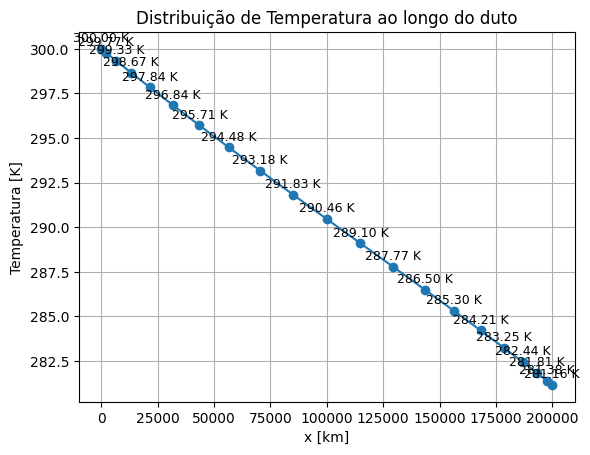

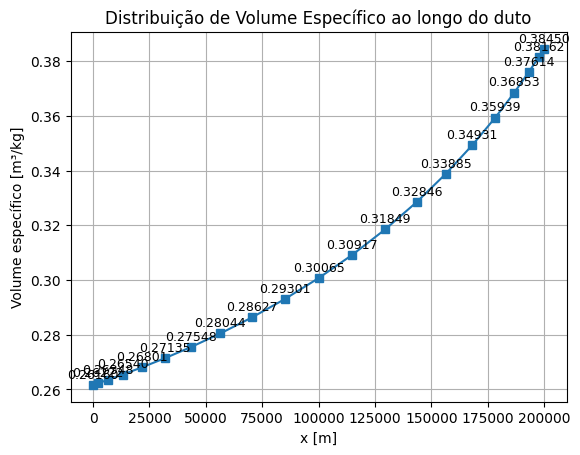

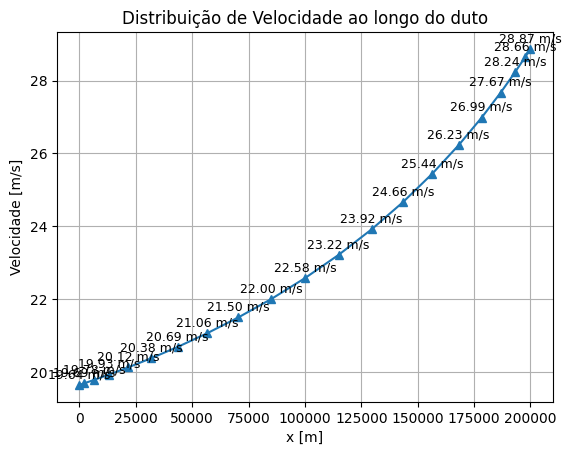

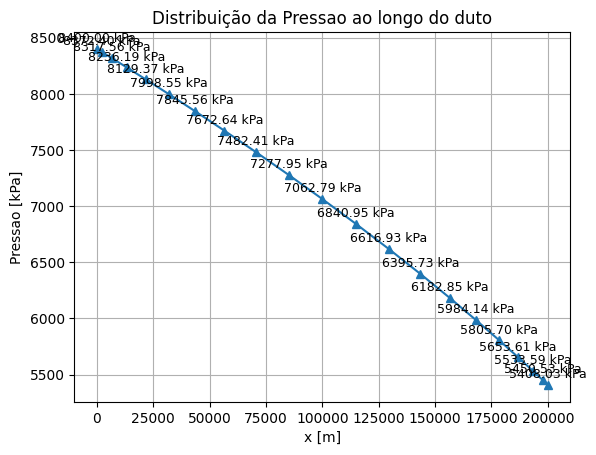

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- Temperatura (K) ---
plt.figure()
plt.plot(x_avaliar, T_sol_estc, marker='o', linestyle='-')
for xi, Ti in zip(x_avaliar, T_sol_estc):
    plt.annotate(f'{Ti:.2f} K', xy=(xi, Ti), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Temperatura ao longo do duto')
plt.xlabel('x [km]')
plt.ylabel('Temperatura [K]')
plt.grid(True)

# --- Volume específico (m³/kg) ---
plt.figure()
plt.plot(x_avaliar, V_sol_estc, marker='s', linestyle='-')
for xi, Vi in zip(x_avaliar, V_sol_estc):
    plt.annotate(f'{Vi:.5f}', xy=(xi, Vi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Volume Específico ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Volume específico [m³/kg]')
plt.grid(True)

# --- Velocidade (m/s) ---
plt.figure()
plt.plot(x_avaliar, w_sol_estc, marker='^', linestyle='-')
for xi, wi in zip(x_avaliar, w_sol_estc):
    plt.annotate(f'{wi:.2f} m/s', xy=(xi, wi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Velocidade ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Velocidade [m/s]')
plt.grid(True)


plt.figure()
plt.plot(x_avaliar, P_sol_estc, marker='^', linestyle='-')
for xi, Pi in zip(x_avaliar, P_sol_estc):
    plt.annotate(f'{Pi:.2f} kPa', xy=(xi, Pi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição da Pressao ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Pressao [kPa]')
plt.grid(True)

plt.show()


In [6]:
x0 = np.concatenate([T_sol_estc, V_sol_estc, w_sol_estc])
y0 = [T_sol_estc[-1], V_sol_estc[1], w_sol_estc[-1]]  # estado inicial completo
print(meu_duto.estacionario(0.0, y0))

(-0.00013921171437404368, 8.24034712377532e-07, 9.072879424649835e-05)


In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# --- Condição inicial (estado estacionário estimado) ---
T0 = T_sol_estc
V0 = V_sol_estc
w0 = w_sol_estc

y0 = np.empty(n_nodes * 3)
y0[0::3] = T0
y0[1::3] = V0
y0[2::3] = w0

# --- Função wrapper para o solve_ivp ---
def dae_wrapper(t, y):
    return meu_duto.evaluate_dae(t, y)

# --- Primeira simulação ---
t_span1 = (0, 100000)
t_eval1 = np.linspace(*t_span1, 100000)

sol1 = solve_ivp(
    dae_wrapper,
    t_span=t_span1,
    y0=y0,
    method='LSODA',
    t_eval=t_eval1
)

# --- Pegar o estado final da primeira simulação ---
y_final = sol1.y[:, -1]   # vetor (n_nodes * 3,)

In [13]:
print(y_final)

[3.00000000e+02 2.61601541e-01 1.96792505e+01 2.99750360e+02
 2.62187303e-01 1.97233151e+01 2.99261401e+02 2.63374723e-01
 1.98126400e+01 2.98550800e+02 2.65192052e-01 1.99493505e+01
 2.97647356e+02 2.67684185e-01 2.01368238e+01 2.96578155e+02
 2.70896961e-01 2.03785082e+01 2.95383985e+02 2.74893793e-01
 2.06791741e+01 2.94090879e+02 2.79720154e-01 2.10422422e+01
 2.92744196e+02 2.85438443e-01 2.14724065e+01 2.91361455e+02
 2.92067847e-01 2.19711104e+01 2.89987463e+02 2.99637468e-01
 2.25405431e+01 2.88629655e+02 3.08101151e-01 2.31772325e+01
 2.87330071e+02 3.17402240e-01 2.38769167e+01 2.86090146e+02
 3.27370360e-01 2.46267789e+01 2.84948609e+02 3.37788458e-01
 2.54104913e+01 2.83907808e+02 3.48292584e-01 2.62006752e+01
 2.83002477e+02 3.58441830e-01 2.69641628e+01 2.82240861e+02
 3.67663890e-01 2.76579020e+01 2.81650995e+02 3.75349875e-01
 2.82360883e+01 2.81244962e+02 3.80890037e-01 2.86528527e+01
 2.81038776e+02 3.83798501e-01 2.88716450e+01]


✅ Simulação concluída!


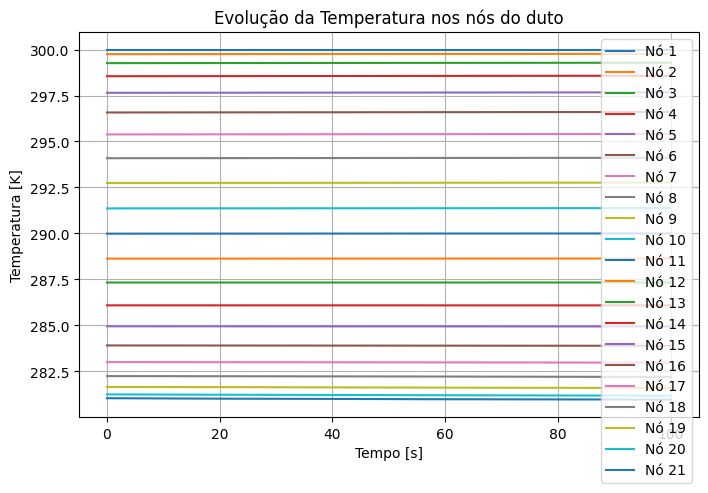

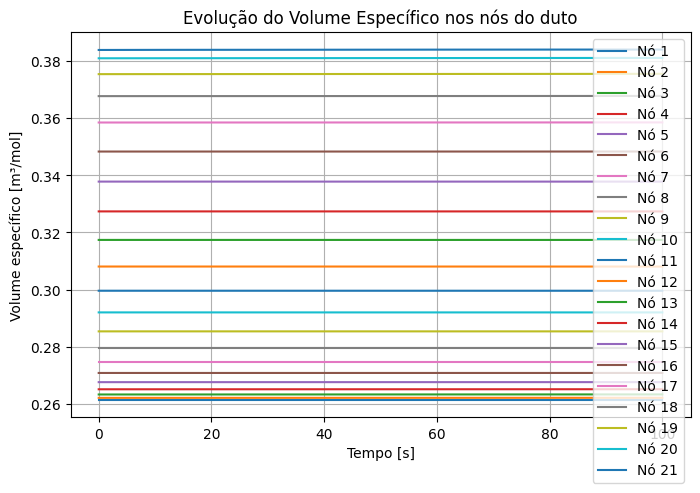

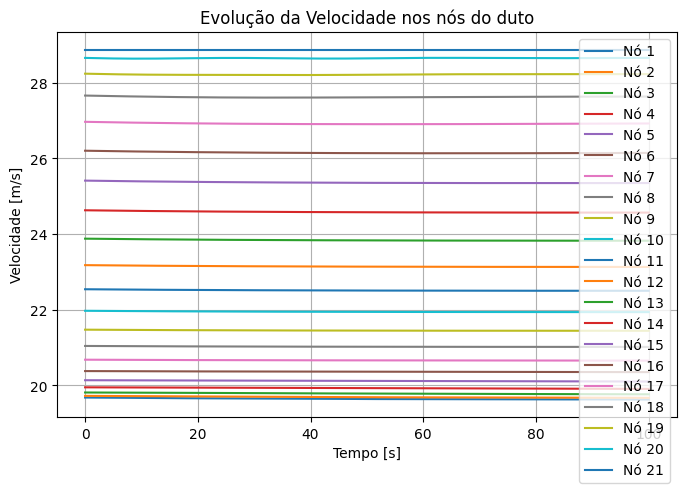

In [14]:
meu_duto_ca = duto_casadi(gas, visc, Lc=200000.0, D=0.42)

y = ca.SX.sym("y", 3 * meu_duto_ca.n_points)
t = ca.SX.sym("t")

dydt = meu_duto_ca.evaluate_dae(t, y)
dae_fun = ca.Function("dae_fun", [t, y], [dydt])

dt = 0.5 
dae = {"x": y, "ode": dydt}
integrador = ca.integrator("integrador", "idas", dae, {"tf": dt})

y0 = y_final  

n_steps = 200
t_sim = np.linspace(0, n_steps * dt, n_steps)
y_sol = np.zeros((n_steps, len(y0)))

y_current = y0
for i in range(n_steps):
    sol = integrador(x0=y_current)
    y_current = np.array(sol["xf"]).flatten()
    y_sol[i, :] = y_current

print("✅ Simulação concluída!")

n_points = meu_duto_ca.n_points
n_t = y_sol.shape[0]

T_sol = np.zeros((n_t, n_points))
V_sol = np.zeros((n_t, n_points))
w_sol = np.zeros((n_t, n_points))

for i in range(n_points):
    T_sol[:, i] = y_sol[:, 3*i + 0]
    V_sol[:, i] = y_sol[:, 3*i + 1]
    w_sol[:, i] = y_sol[:, 3*i + 2]

x = meu_duto_ca.l  

plt.figure(figsize=(8, 5))
plt.title("Evolução da Temperatura nos nós do duto")
for i in range(n_points):
    plt.plot(t_sim, T_sol[:, i], label=f"Nó {i+1}")
plt.xlabel("Tempo [s]")
plt.ylabel("Temperatura [K]")
plt.grid(True)
plt.legend()
plt.show()

# --- Volume específico ---
plt.figure(figsize=(8, 5))
plt.title("Evolução do Volume Específico nos nós do duto")
for i in range(n_points):
    plt.plot(t_sim, V_sol[:, i], label=f"Nó {i+1}")
plt.xlabel("Tempo [s]")
plt.ylabel("Volume específico [m³/mol]")
plt.grid(True)
plt.legend()
plt.show()

# --- Velocidade ---
plt.figure(figsize=(8, 5))
plt.title("Evolução da Velocidade nos nós do duto")
for i in range(n_points):
    plt.plot(t_sim, w_sol[:, i], label=f"Nó {i+1}")
plt.xlabel("Tempo [s]")
plt.ylabel("Velocidade [m/s]")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
A = np.pi * (meu_duto.D**2) / 4
MM = meu_duto.gas.mixture.MM_m  # massa molar em kg/mol

# Número de instantes de tempo
n_t = len(sol2.t)

# Inicializa matriz de vazões mássicas (5 nós x n_t tempos)
m_dot = np.zeros((n_nodes, n_t))

# Calcula a vazão mássica para cada nó e tempo
for t_idx in range(n_t):
    for node in range(n_nodes):
        T = sol2.y[0::3][node][t_idx]
        V = sol2.y[1::3][node][t_idx]
        w = sol2.y[2::3][node][t_idx]

        v_kg = V / MM
        rho = 1 / v_kg
        m_dot[node, t_idx] = rho * A * w  # vazão mássica [kg/s]

# Plot da vazão mássica ao longo do tempo para os 5 nós
plt.figure(figsize=(10, 6))
for i in range (n_nodes):
    plt.plot(sol2.t, m_dot[i], label=f'Nó {i}')
plt.xlabel('Tempo [s]')
plt.ylabel('Vazão mássica [kg/s]')
plt.title('Evolução da Vazão Mássica nos 5 Nós')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain')
plt.tight_layout()
plt.show()